In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, TensorDataset, Dataset
import matplotlib.pyplot as plt
import torch.nn.functional as Fun
import math
from matplotlib import pyplot as plt

In [2]:
#device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
# use cuda if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Load traces

In [3]:
traces_file = 'traces.csv'
nrows = 2095629 # number of traces to use (debug purposes)
# nrows = 64000 # number of traces to use (debug purposes)
batch_size = 64
sequence_length = 16
target_length = 10
print('number of traces: ', len(pd.read_csv(traces_file)))
print('number of traces used: ', nrows)

traces = pd.read_csv(traces_file, nrows=nrows)
print(traces[0:100])
# Split into train and test
dataset_length = 2095629
train_data = traces[:3*int(dataset_length/4)]
test_data = traces[3*int(dataset_length/4):]

print(len(train_data))
# get number of unique values in each column
print('number of unique values to predict: ', traces.nunique()[-1])

number of traces:  2095629
number of traces used:  2095629
    pc     delta_in    delta_out
0    0            0     58913654
1    0     58913654 -11440181528
2    0 -11440181528  11381267426
3    0  11381267426           -1
4    0           -1            2
..  ..          ...          ...
95   0            1            1
96   0            1            1
97   0            1            1
98   0            1            1
99   0            1            1

[100 rows x 3 columns]
1571721
number of unique values to predict:  15


### Create vocabulary

In [4]:
# Cuda details should not be part of dataset.
label_encoder_pc = LabelEncoder()
label_encoder_deltas = LabelEncoder()
class PrefetchingDataset(Dataset):
    def __init__(self, pc, delta_in):
        #self.targets = targets
        self.label_encoders_deltas = LabelEncoder()
        self.label_encoders_deltas.fit(delta_in)
        self.pcs = pc
        self.delta_in = self.label_encoders_deltas.transform(delta_in)
    
    def __len__(self):
        return (int(batch_size * math.floor(len(self.delta_in)/batch_size)) - batch_size)

    def __getitem__(self, idx):
        #pcs = Fun.one_hot(torch.tensor(self.pcs[idx:idx+sequence_length]), max(num_pc, num_output_next))
        #deltas = Fun.one_hot(torch.tensor(self.delta_in[idx:idx+sequence_length]), max(num_pc, num_output_next))
        #pcs = torch.tensor(self.pcs[idx:idx+sequence_length])
        pcs = self.pcs[idx:idx+sequence_length]
        deltas = torch.tensor(self.delta_in[idx:idx+sequence_length])
        # predict just one target.
        #targets = Fun.one_hot(torch.tensor(self.delta_in[idx+sequence_length]), num_output_next)
        #predict multiple targets
        #targets = Fun.one_hot(torch.tensor(self.delta_in[idx+sequence_length: idx+sequence_length+target_length]), num_output_next)
        targets = torch.zeros(17, dtype=torch.float32)
        # (x for x in xyz if x not in a)
        intermediate_deltas= [x for x in self.label_encoders_deltas.inverse_transform(self.delta_in[idx+sequence_length: idx+sequence_length+target_length]) if x > 0 and x < 18]
        sum = torch.cumsum(torch.tensor(intermediate_deltas), dim=0)
        targets[sum] = 1
        return (pcs, deltas, targets)

def load_data(data, batch_size):
    deltas = data['delta_in']
    #deltas.tolist().append(data['delta_out'].tolist())
    # Fit label encoder and transform labels into encoded values
    data['pc_encoded'] = label_encoder_pc.transform(data['pc'].values)
    
    # This can't work, first we have to concat both data in and out and then assign labels.
    #label_encoder_deltas.fit(deltas)
    
    #data['delta_in_encoded'] = label_encoder_deltas.transform(data['delta_in'].values)
    #print(data['delta_in_encoded'].values[0:10])
    #data['delta_out_encoded'] = label_encoder_deltas.transform(data['delta_out'])
    #print(label_encoder_deltas.inverse_transform(data['delta_in_encoded'].values[0:10]))
    # Convert dataframes to tensors
    pc = torch.tensor(data['pc_encoded'].values)
    #delta_in = torch.tensor(data['delta_in_encoded'].values)
    #print("Deltas:", len(delta_in))
    #targets = torch.tensor(data['delta_out_encoded'].values)

    # Create a custom Dataset instance
    #dataset = TensorDataset(pc, delta_in, targets)
    dataset = PrefetchingDataset(pc, deltas)
    print("Dataset:", len(dataset))
    # Create a DataLoader instance
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    # Get unique target keys
    target_keys = set(deltas.unique())
    print("Data loader", len(data_loader))
    return data_loader, len(label_encoder_pc.classes_), len(label_encoder_deltas.classes_), len(label_encoder_deltas.classes_), target_keys

label_encoder_pc.fit(list(set().union(train_data['pc'].values, test_data['pc'].values)))
label_encoder_deltas.fit(list(set().union(train_data['delta_in'].values, test_data['pc'].values)))
train_iter, num_pc, num_delta_in, num_output_next, target_keys = load_data(train_data, batch_size=batch_size)
test_iter, _, _, _, _ = load_data(test_data, batch_size=batch_size)
# add 1 for the next delta which is not in the training set
num_pc += 1
num_delta_in += 1
num_output_next += 1
print("Train iter:", len(train_iter))
print('number of unique pc: ', num_pc)
print('number of unique input delta: ', num_delta_in)
print('number of unique output delta: ', num_output_next)


Dataset: 1571680
Data loader 49115
Dataset: 523872
Data loader 16371
Train iter: 49115
number of unique pc:  2
number of unique input delta:  17
number of unique output delta:  17


/tmp/ipykernel_137469/3462415718.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['pc_encoded'] = label_encoder_pc.transform(data['pc'].values)
/tmp/ipykernel_137469/3462415718.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['pc_encoded'] = label_encoder_pc.transform(data['pc'].values)


In [5]:
# Histogram of the data.
#plt.hist(train_data['delta_in_encoded'], bins=100, range=[0,5000])
#plt.show()

In [6]:
#plt.hist(test_data['delta_in_encoded'], bins=100, range=[0,5000])
#plt.show()

### Define LSTM model

In [7]:
class EmbeddingLSTM(nn.Module):
    def __init__(self, num_pc, num_delta_in, num_output_next, embed_dim, hidden_dim, output_dim, topPredNum, num_layers, dropout):
        # Layer structure is described in the paper
        super(EmbeddingLSTM, self).__init__()
        self.topPredNum = topPredNum
        # Define embedding layers
        # TODO(yisheng): Num_pc should be the input history size.
        self.pc_embed_layer = nn.Embedding(num_pc, embed_dim)
        # TODO(yisheng): Num_pc and num_delta will be the same
        self.delta_embed_layer = nn.Embedding(num_delta_in, embed_dim)
        # Define LSTM layer
        # LSTM input dimension: (pc_embed + delta_embed) * 2
        # What does concat mean? and dimension should be the same as embed_dim
        lstm_input_dim = embed_dim
        self.lstm = nn.LSTM(lstm_input_dim, hidden_dim, num_layers, dropout=dropout, batch_first=True)
        # Define output layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        # Define dropout layer
        # TODO: why is this needed?
        self.dropout = nn.Dropout(p=dropout)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, h_c_state, target=None):
        pc, delta = x
        pc_embed = self.pc_embed_layer(pc)
        delta_embed = self.delta_embed_layer(delta)
        #pc_delta_embed_out = torch.cat([pc_embed, delta_embed], dim = -1).to(torch.float32)
        lstm_out, (h_0, c_0) = self.lstm(delta_embed, h_c_state)
        # lstm_out shape: (batch_size, seq_len, hidden_dim)
        #outputs = self.fc(lstm_out)
        state = (h_0, c_0)
        #out = h_0[-1]
        #out_dropout = self.dropout(h_0[-1])
        out = self.fc(h_0[-1])
        
        out = self.sigmoid(out)
        if target is not None:
            loss = nn.BCELoss()(out, target.to(torch.float32)) 
        else:
            loss = None
        
        # Get top k predictions
        _, preds = torch.topk(out, self.topPredNum, sorted=False)
        return preds, state, loss

    def predict(self, X, lstm_state):
        with torch.no_grad():
            preds, state, _ = self.forward(X, lstm_state)
            return preds, state



### Tune hyperparameters here

In [8]:
# Set up hyperparameters
hparams = {
    "topPredNum": 10,
    "embed_dim": 128,
    "hidden_dim": 128,
    "output_dim": num_output_next,
    "num_layers": 2,
    "dropout": 0,
    "learning_rate": 0.005,
    "epochs": 1
}

### Train the model

In [9]:
# Initialize the model with hyperparameters
my_model = EmbeddingLSTM(
    num_pc,
    num_delta_in,
    num_output_next,
    hparams["embed_dim"],
    hparams["hidden_dim"],
    hparams["output_dim"],
    topPredNum=hparams["topPredNum"],
    num_layers=hparams["num_layers"],
    dropout=hparams["dropout"]
)

# Prepare for training
train_loss = []
my_model = my_model.to(device)
optimizer = torch.optim.Adam(my_model.parameters(), lr=hparams["learning_rate"])

# Start training
for epoch in range(hparams["epochs"]):
    # Switch to training mode
    my_model.train()
    h_0 = torch.zeros(hparams["num_layers"], batch_size, hparams["hidden_dim"]).to(device)
    c_0 = torch.zeros(hparams["num_layers"], batch_size, hparams["hidden_dim"]).to(device)
    lstm_state = (h_0, c_0)
    for idx, batch in enumerate(train_iter):
        batch = [ds.to(device) for ds in batch]
        inputs = batch[:-1]
        targets = batch[-1]
        optimizer.zero_grad()
        _, lstm_state, batch_loss = my_model(inputs, lstm_state, targets)
        batch_loss.backward()
        optimizer.step()
        train_loss.append(float(batch_loss.item()))
        if idx%1000 == 0:
            print(f"Epoch {epoch + 1}, Iteration {idx + 1}, Loss: {train_loss[-1]:.8f}")
        lstm_state = tuple([s.data for s in lstm_state])    

Epoch 1, Iteration 1, Loss: 0.69270480
Epoch 1, Iteration 1001, Loss: 0.00001067
Epoch 1, Iteration 2001, Loss: 0.00000328
Epoch 1, Iteration 3001, Loss: 0.00000147
Epoch 1, Iteration 4001, Loss: 0.00000076
Epoch 1, Iteration 5001, Loss: 0.00000043
Epoch 1, Iteration 6001, Loss: 0.00000025
Epoch 1, Iteration 7001, Loss: 0.00000014
Epoch 1, Iteration 8001, Loss: 0.00000007
Epoch 1, Iteration 9001, Loss: 0.00000003
Epoch 1, Iteration 10001, Loss: 0.00000002
Epoch 1, Iteration 11001, Loss: 0.00000001
Epoch 1, Iteration 12001, Loss: 0.00000000
Epoch 1, Iteration 13001, Loss: 0.00000000
Epoch 1, Iteration 14001, Loss: 0.00000000
Epoch 1, Iteration 15001, Loss: 0.00000000
Epoch 1, Iteration 16001, Loss: 0.00000000
Epoch 1, Iteration 17001, Loss: 0.00000000
Epoch 1, Iteration 18001, Loss: 0.00000000
Epoch 1, Iteration 19001, Loss: 0.00000000
Epoch 1, Iteration 20001, Loss: 0.00000000
Epoch 1, Iteration 21001, Loss: 0.00000000
Epoch 1, Iteration 22001, Loss: 0.00000000
Epoch 1, Iteration 23001

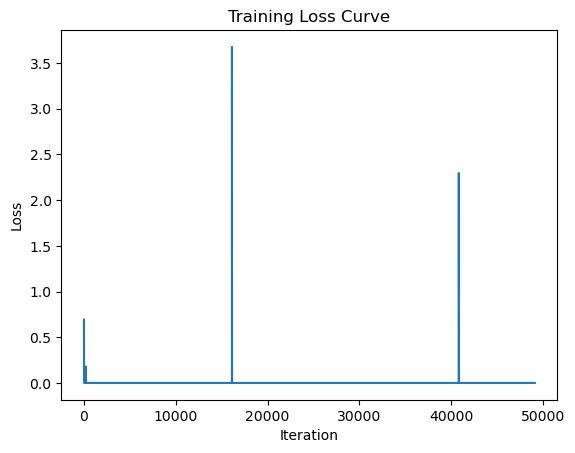

In [10]:
plt.plot(train_loss)
plt.title("Training Loss Curve")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

### Validate the model

In [11]:
def validate_model(network, data_iterator, relevant_keys, computing_device="cpu", initial_state=None):
    network.eval()

    accuracy_metrics = [process_batch(i, batch_data, network, computing_device, initial_state, relevant_keys) 
                        for i, batch_data in enumerate(data_iterator)]

    average_accuracy = torch.tensor(accuracy_metrics).mean()
    print("Average Validation Accuracy: {:.4f}".format(average_accuracy))

def process_batch(batch_index, batch_data, network, device, state, keys):
    print(f"Processing batch {batch_index}")

    batch_data = [item.to(device) for item in batch_data]
    input_data = batch_data[:-1]
    labels = batch_data[-1]
    labels = torch.argmax(labels, dim = 1)
    
    predictions, state = network.predict(input_data, state)
    accuracy = compute_accuracy(predictions, labels, keys)

    return accuracy

def compute_accuracy(predictions, labels, keys):
    combined_data = list(zip(labels, predictions))
    count_correct = sum([1 for label, predicted in combined_data 
                         if label.item() in keys and label in predicted])
    
    return count_correct / len(labels)

validate_model(my_model, train_iter, target_keys, computing_device=device)


Processing batch 0
Processing batch 1
Processing batch 2
Processing batch 3
Processing batch 4
Processing batch 5
Processing batch 6
Processing batch 7
Processing batch 8
Processing batch 9
Processing batch 10
Processing batch 11
Processing batch 12
Processing batch 13
Processing batch 14
Processing batch 15
Processing batch 16
Processing batch 17
Processing batch 18
Processing batch 19
Processing batch 20
Processing batch 21
Processing batch 22
Processing batch 23
Processing batch 24
Processing batch 25
Processing batch 26
Processing batch 27
Processing batch 28
Processing batch 29
Processing batch 30
Processing batch 31
Processing batch 32
Processing batch 33
Processing batch 34
Processing batch 35
Processing batch 36
Processing batch 37
Processing batch 38
Processing batch 39
Processing batch 40
Processing batch 41
Processing batch 42
Processing batch 43
Processing batch 44
Processing batch 45
Processing batch 46
Processing batch 47
Processing batch 48
Processing batch 49
Processing

In [12]:
validate_model(my_model, test_iter, target_keys, computing_device=device)


Processing batch 0
Processing batch 1
Processing batch 2
Processing batch 3
Processing batch 4
Processing batch 5
Processing batch 6
Processing batch 7
Processing batch 8
Processing batch 9
Processing batch 10
Processing batch 11
Processing batch 12
Processing batch 13
Processing batch 14
Processing batch 15
Processing batch 16
Processing batch 17
Processing batch 18
Processing batch 19
Processing batch 20
Processing batch 21
Processing batch 22
Processing batch 23
Processing batch 24
Processing batch 25
Processing batch 26
Processing batch 27
Processing batch 28
Processing batch 29
Processing batch 30
Processing batch 31
Processing batch 32
Processing batch 33
Processing batch 34
Processing batch 35
Processing batch 36
Processing batch 37
Processing batch 38
Processing batch 39
Processing batch 40
Processing batch 41
Processing batch 42
Processing batch 43
Processing batch 44
Processing batch 45
Processing batch 46
Processing batch 47
Processing batch 48
Processing batch 49
Processing